### Goal

Evaluate whether moving the gate from level 30 to level 40 affects player retention.

Before running a Z-test, we validate:
- data integrity
- randomization
- suitability of statistical assumptions

Statistical test:
- Two-proportion Z-test

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

In [35]:
df = pd.read_csv("cookie_cats.csv")

df.head(), df.shape


(   userid  version  sum_gamerounds  retention_1  retention_7
 0     116  gate_30               3        False        False
 1     337  gate_30              38         True        False
 2     377  gate_40             165         True        False
 3     483  gate_40               1        False        False
 4     488  gate_40             179         True         True,
 (90189, 5))

### Data Integrity Checks

Why this matters:
- A/B testing assumes each user appears once
- Missing or malformed data can invalidate conclusions


In [38]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

In [ ]:
duplicates = df["userid"].duplicated().sum()
duplicates
# Each user must belong to exactly one experimental group.

np.int64(0)

### Randomization Check

We verify whether users are roughly evenly split between variants.
Perfect balance is not required but extreme imbalance is a red flag.

In [ ]:
df["version"].value_counts(normalize=True)

version
gate_40    0.504374
gate_30    0.495626
Name: proportion, dtype: float64

### Outcome Distribution

We inspect overall retention rates without splitting by group.
This avoids peeking bias before hypothesis testing.

In [ ]:
df["retention_1"].value_counts(normalize=True)

retention_1
False    0.55479
True     0.44521
Name: proportion, dtype: float64

In [ ]:
df["retention_7"].value_counts(normalize=True)

retention_7
False    0.813935
True     0.186065
Name: proportion, dtype: float64

### Inspecting sum_gamerounds

This variable is not used in the z test.
We inspect it to understand data quality and detect anomalies.

Important:
- Behavioral data is expected to be heavy-tailed
- Extreme values are not automatically errors

In [45]:
df["sum_gamerounds"].describe()


count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

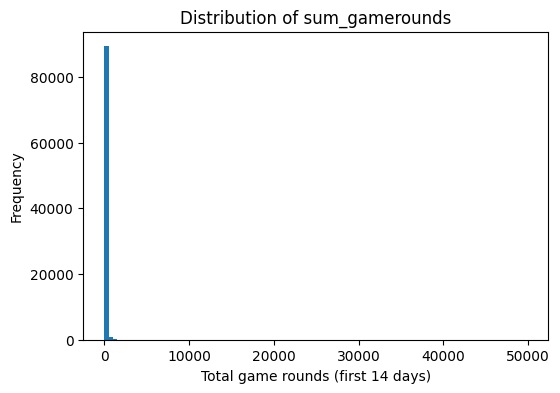

In [63]:
plt.figure(figsize=(6,4))
plt.hist(df["sum_gamerounds"], bins=100)
plt.xlabel("Total game rounds (first 14 days)")
plt.ylabel("Frequency")
plt.title("Distribution of sum_gamerounds")
plt.show()


### Outlier Inspection

Purpose:
- Identify extreme values but not to remove them

Outliers are expected in engagement data and
do not affect binary retention tests.

In [66]:
Q1 = df["sum_gamerounds"].quantile(0.25)
Q3 = df["sum_gamerounds"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

outliers=df[(df["sum_gamerounds"] < lower) | (df["sum_gamerounds"] > upper)]
outliers.shape[0], outliers.shape[0] / df.shape[0]


(10177, 0.11284081207242569)

In [ ]:
### Group Split
A = df[df["version"] == "gate_30"]
B = df[df["version"] == "gate_40"]


### Two-Proportion Z-Test – Retention Day 1 

Retention_1 measures short-term engagement.
It is analyzed to detect early behavioral effects.

Hypotheses:
H0: retention_1(A) = retention_1(B)
H1: retention_1(A) =! retention_1(B)



In [69]:
success_A1 = A["retention_1"].sum()
success_B1 = B["retention_1"].sum()

n_A = len(A)
n_B = len(B)

counts_1 = np.array([success_A1, success_B1])
nobs = np.array([n_A, n_B])

z1, p1 = proportions_ztest(counts_1, nobs)

rate_A1 = success_A1 / n_A
rate_B1 = success_B1 / n_B

diff_1 = rate_B1 - rate_A1

print(f"z-score = {z1:.3f}")
print(f"p-value= {p1:.4f}")
print(f"Conversion rate – Group A = {rate_A1:.4%}")
print(f"Conversion rate – Group B = {rate_B1:.4%}")
print(f"Absolute difference: B−A = {diff_1:.4%}")


z-score = 1.784
p-value= 0.0744
Conversion rate – Group A = 44.8188%
Conversion rate – Group B = 44.2283%
Absolute difference: B−A = -0.5905%


np.int64(20034)

### Interpretation – Retention_1

Decision rule:
- p value < 0.05 means statistically significant difference

However:
- retention 1 captures short-term behavior
- It may reflect novelty or onboarding effects
- Business decisions should not rely on retention_1 alone

### Two-Proportion Z-Test - Retention Day 2

Hypotheses:
H0: retention_7(A) = retention_7(B)
H1: retention_7(A) =! retention_7(B)

In [70]:
success_A = A["retention_7"].sum()
success_B = B["retention_7"].sum()

n_A = len(A)
n_B = len(B)

counts = np.array([success_A, success_B])
nobs = np.array([n_A, n_B])

z7, p7 = proportions_ztest(counts, nobs)

rate_A7 = success_A / n_A
rate_B7 = success_B / n_B

diff_7 = rate_B7 - rate_A7

print(f"Z-score = {z7:.3f}")
print(f"p (p-value) = {p7:.4f}")
print(f"Conversion rate – Group A = {rate_A7:.4%}")
print(f"Conversion rate – Group B = {rate_B7:.4%}")
print(f"Absolute difference: B−A = {diff_7:.4%}")


Z-score = 3.164
p (p-value) = 0.0016
Conversion rate – Group A = 19.0201%
Conversion rate – Group B = 18.2000%
Absolute difference: B−A = -0.8201%


### Interpretation

Decision rule:
- p-value < 0.05 means statistically significant difference

Important:
- Statistical significance does NOT imply business significance
- Effect size must be considered before making product decisions


### Takeaway
Day-1 retention does not show a statistically significant difference,
indicating that early user experience is unaffected.
However, day-7 retention shows a statistically significant difference
(p = 0.0016), suggesting a meaningful impact on mid-term user retention.
Therefore, decisions should be based primarily on retention_7.

In [71]:


# Effect size
absolute_diff_7 = rate_B7 - rate_A7
relative_lift_7 = absolute_diff_7 / rate_A7

rate_A7, rate_B7, absolute_diff_7, relative_lift_7


(np.float64(0.19020134228187918),
 np.float64(0.18200004396667327),
 np.float64(-0.008201298315205913),
 np.float64(-0.043119034896460164))

In [72]:
def bootstrap_ci_diff(groupA, groupB, column, n_boot=5000, alpha=0.05):
    diffs = []

    for _ in range(n_boot):
        samp_A = groupA[column].sample(frac=1, replace=True).mean()
        samp_B = groupB[column].sample(frac=1, replace=True).mean()
        diffs.append(samp_B - samp_A)

    lower = np.percentile(diffs, 100 * (alpha / 2))
    upper = np.percentile(diffs, 100 * (1 - alpha / 2))

    return lower, upper


In [73]:
CI_low_7, CI_high_7 = bootstrap_ci_diff(A, B, "retention_7")

CI_low_7, CI_high_7


(np.float64(-0.01333365670231361), np.float64(-0.0028757530583763758))

In [74]:
CI_low_1, CI_high_1 = bootstrap_ci_diff(A, B, "retention_1")

CI_low_1, CI_high_1


(np.float64(-0.012160539217313544), np.float64(0.000537246190206643))

### Final Decision

Retention_1 shows no statistically significant difference, and its confidence
interval includes zero, indicating no clear short-term impact.

Retention_7 shows a statistically significant negative effect for gate_40.
The 95% confidence interval does not include zero, confirming that the
observed decrease in retention is robust.

Although the absolute effect size is small, the consistent negative direction
suggests that moving the gate to level 40 harms mid-term player retention.
